# SWG/SCG Collapse Analysis – SXS:BBH:0305

This notebook demonstrates how Structured Wave Geometry (SWG) and Structured Coherence Geometry (SCG) can be applied to gravitational wave data.  
The goal is to map the dominant black-hole merger mode into SWG primitives (amplitude, phase, memory/curvature), compute coherence invariants, and diagnose the collapse window.  

We use a two-pass approach:
- **Coarse scan** – robust detection over wide windows.  
- **Refined scan** – localized detection around collapse.  

The notebook outputs both diagnostics (entropy, curvature, flux) and SCG projections, showing how collapse emerges as a coherence event in the waveform.  


Refined collapse window: [3777.13, 3844.32]  (mid=3810.72, merger=3692.65)
Offset (mid - merger): 118.08 M
Merger inside collapse window: False
Durations — coarse: 1780.81 M, refined: 67.20 M


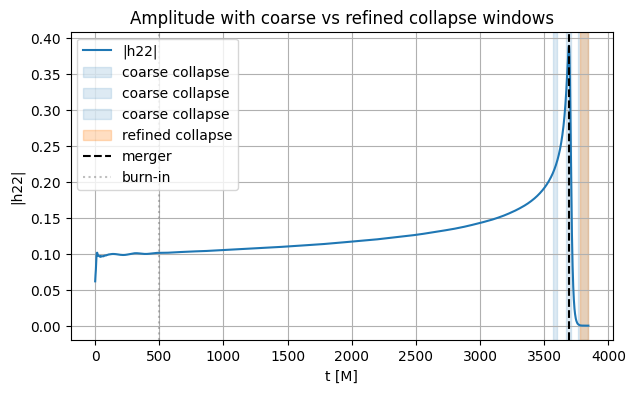

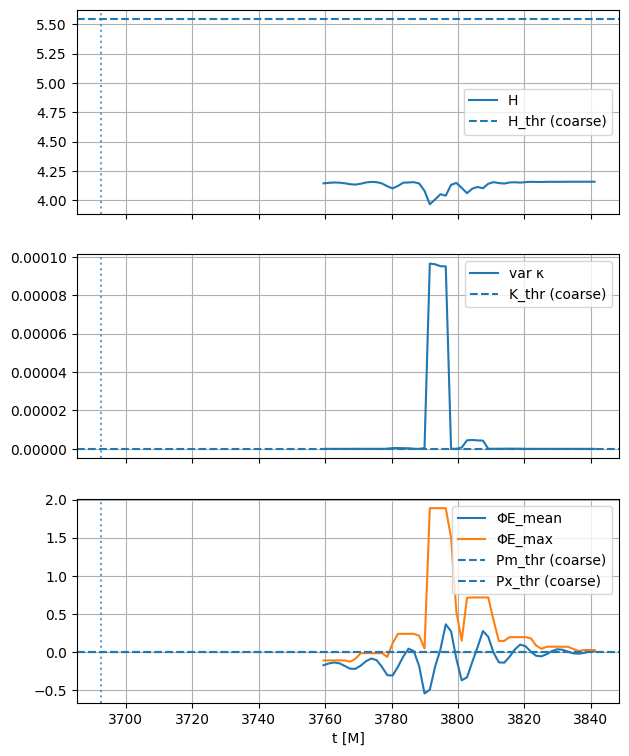

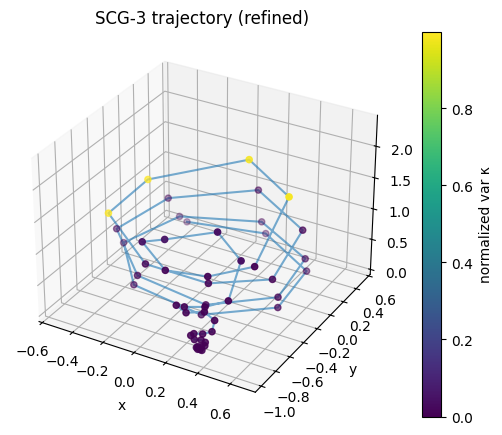

In [8]:
# ======================= SWG/SCG Black-Hole Collapse (single cell) =======================
# Imports & plotting
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.signal import stft
import sxs

plt.rcParams.update({"figure.figsize": (7,4), "axes.grid": True})

# ------------------------- Load waveform & map to primitives -----------------------------
sim = sxs.load("SXS:BBH:0305")
h = sim.strain
t = h.t                                   # geometric units (M)
h22 = h.data[:, h.index(2, 2)]            # (l=2, m=2) mode
EPS = 1e-12
A = np.abs(h22)                            # amplitude
theta = np.unwrap(np.angle(h22))           # intrinsic phase (stable frame)
dt = float(np.median(np.diff(t)))          # time step (uniform-enough)
# programmatic merger time = time of peak |h22|
i_peak = int(np.argmax(A))
t_merger = float(t[i_peak])

# ------------------------------- Helpers -------------------------------------------------
def grad1(x, dt):
    g = np.empty_like(x, dtype=float)
    g[1:-1] = (x[2:] - x[:-2])/(2*dt)
    g[0]    = (x[1] - x[0])/dt
    g[-1]   = (x[-1] - x[-2])/dt
    return g

def lap1(x):
    L = np.empty_like(x, dtype=float)
    xm = np.concatenate(([x[0]], x, [x[-1]]))  # edge-mirror
    L[:] = xm[2:] - 2*x + xm[:-2]
    return L

def mad_sigma(x, axis=None):
    med = np.median(x, axis=axis)
    mad = np.median(np.abs(x - med), axis=axis)
    return med, 1.4826 * mad

def windows(n, win_len, hop):
    i = 0
    while i + win_len <= n:
        yield i, i + win_len
        i += hop

# Optional TF-curvature (diagnostic only; not used for SCG z by default)
def tf_curvature(A, t, nperseg=256, noverlap=192):
    fs = 1.0 / float(np.median(np.diff(t)))
    f, tt, Z = stft(A, fs=fs, nperseg=nperseg, noverlap=noverlap, boundary=None)
    S = np.abs(Z) + EPS
    Sp = np.pad(S, ((1,1),(1,1)), mode='edge')
    L2 = Sp[2:,1:-1] + Sp[:-2,1:-1] + Sp[1:-1,2:] + Sp[1:-1,:-2] - 4*Sp[1:-1,1:-1]
    kappa2 = np.median(np.abs(L2), axis=0)
    idx = np.clip(np.searchsorted(t, tt), 0, len(t)-1)
    out = np.zeros_like(A)
    out[idx] = kappa2 / (np.median(S) + EPS)
    return out

# ------------------------------- Curvature channels -------------------------------------
kappa_t = np.abs(lap1(A)) / (A + EPS)     # time-domain curvature (dimensionless)
# kappa_tf = tf_curvature(A, t)           # optional diagnostic (not used in z)

# ------------------------------- Invariants (windowed) ----------------------------------
@dataclass
class InvWindow:
    t0: float; t1: float
    H: float; var_kappa: float
    PhiE_mean: float; PhiE_max: float
    x: float; y: float; z: float
    i0: int; i1: int

def coherence_entropy(Aw):
    w = Aw + EPS
    p = w / np.sum(w)
    return -np.sum(p * np.log(p + EPS))

def scg_project(Aw, thw, kw, w=None):
    if w is None:
        w = Aw/(Aw.max()+EPS)
    c, s = np.cos(thw), np.sin(thw)
    x = np.sum(w * c); y = np.sum(w * s); z = np.sum(w * kw * w)
    return x, y, z

def invariants_over_windows(t, A, theta, kappa_z, win_M, hop_M):
    E_loc = A**2                              # local proxy (not full functional)
    PhiE = grad1(E_loc, float(np.median(np.diff(t)))) / (E_loc + EPS)
    out = []
    for i0, i1 in windows(len(t), win_M, hop_M):
        Aw, thw, kw = A[i0:i1], theta[i0:i1], kappa_z[i0:i1]
        H = coherence_entropy(Aw)
        var_kappa = float(np.var(kw))
        PhiE_mean = float(np.mean(PhiE[i0:i1]))
        PhiE_max  = float(np.max(PhiE[i0:i1]))
        pw = Aw / (Aw.sum() + EPS)
        x,y,z = scg_project(Aw, thw, kw, w=pw)
        out.append(InvWindow(t[i0], t[i1], H, var_kappa, PhiE_mean, PhiE_max, x,y,z, i0, i1))
    return out

def contiguous_regions(mask):
    idx = np.where(mask)[0]
    if len(idx)==0: return []
    regions=[]; start=idx[0]; prev=idx[0]
    for j in idx[1:]:
        if j==prev+1: prev=j
        else: regions.append((start,prev)); start=j; prev=j
    regions.append((start,prev))
    return regions

# --------------------------------- Coarse scan ------------------------------------------
BURN_IN = 500.0
WIN_COARSE, HOP_COARSE = 256, 64
inv_coarse = invariants_over_windows(t, A, theta, kappa_t, win_M=WIN_COARSE, hop_M=HOP_COARSE)

Hc  = np.array([w.H for w in inv_coarse])
Kc  = np.array([w.var_kappa for w in inv_coarse])
Pmc = np.array([w.PhiE_mean for w in inv_coarse])
Pxc = np.array([w.PhiE_max  for w in inv_coarse])
tc_mid = np.array([(w.t0+w.t1)/2 for w in inv_coarse])

H_med,H_sig = mad_sigma(Hc); K_med,K_sig = mad_sigma(Kc)
Pm_med,Pm_sig = mad_sigma(Pmc); Px_med,Px_sig = mad_sigma(Pxc)
H_thr  = H_med - 2.0*H_sig
K_thr  = K_med + 2.0*K_sig
Pm_thr = Pm_med + 2.0*Pm_sig
Px_thr = Px_med + 2.0*Px_sig

cond_H = Hc <= H_thr
cond_K = Kc >= K_thr
cond_P = (Pmc >= Pm_thr) | (Pxc >= Px_thr)
collapse_coarse = cond_H & cond_K & cond_P & (tc_mid >= BURN_IN)
regions = contiguous_regions(collapse_coarse)

if not regions:
    raise RuntimeError("No collapse found in coarse pass.")

# select best coarse region (curvature-first; tie by flux max, then lowest entropy)
best = None
best_key = (-1.0, -1.0, 1e9)
for a,b in regions:
    kmax = float(np.max(Kc[a:b+1]))
    px   = float(np.max(Pxc[a:b+1]))
    hmin = float(np.min(Hc[a:b+1]))
    key  = (kmax, px, -hmin)
    if key > best_key:
        best_key = key
        best = (a,b)
a,b = best
t_focus = (inv_coarse[a].t0, inv_coarse[b].t1)

# --------------------------------- Refined scan -----------------------------------------
WIN_FINE, HOP_FINE = 64, 16
mask = (t >= t_focus[0]-WIN_FINE*dt) & (t <= t_focus[1]+WIN_FINE*dt)
inv_fine = invariants_over_windows(t[mask], A[mask], theta[mask], kappa_t[mask],
                                   win_M=WIN_FINE, hop_M=HOP_FINE)

Hf  = np.array([w.H for w in inv_fine])
Kf  = np.array([w.var_kappa for w in inv_fine])
Pmf = np.array([w.PhiE_mean for w in inv_fine])
Pxf = np.array([w.PhiE_max  for w in inv_fine])
tf_mid = np.array([(w.t0+w.t1)/2 for w in inv_fine])

# reuse coarse thresholds for stability
cond_Hf = Hf <= H_thr
cond_Kf = Kf >= K_thr
cond_Pf = (Pmf >= Pm_thr) | (Pxf >= Px_thr)
collapse_fine = cond_Hf & cond_Kf & cond_Pf
regions_fine = contiguous_regions(collapse_fine)
if not regions_fine:
    raise RuntimeError("No refined collapse found.")

# select best refined region (curvature-first; tie by flux max, then lowest entropy)
best = None
best_key = (-1.0, -1.0, 1e9)
for a,b in regions_fine:
    kmax = float(np.max(Kf[a:b+1]))
    px   = float(np.max(Pxf[a:b+1]))
    hmin = float(np.min(Hf[a:b+1]))
    key  = (kmax, px, -hmin)
    if key > best_key:
        best_key = key
        best = (a,b)
a,b = best
t_coll_start, t_coll_end = inv_fine[a].t0, inv_fine[b].t1
t_coll_mid = 0.5*(t_coll_start + t_coll_end)

# ------------------------------ Report offset & coverage --------------------------------
offset_mid = t_coll_mid - t_merger
covers_merger = (t_coll_start <= t_merger <= t_coll_end)
dur_coarse = inv_coarse[b].t1 - inv_coarse[a].t0
dur_refined = t_coll_end - t_coll_start

print(f"Refined collapse window: [{t_coll_start:.2f}, {t_coll_end:.2f}]  "
      f"(mid={t_coll_mid:.2f}, merger={t_merger:.2f})")
print(f"Offset (mid - merger): {offset_mid:.2f} M")
print(f"Merger inside collapse window: {covers_merger}")
print(f"Durations — coarse: {dur_coarse:.2f} M, refined: {dur_refined:.2f} M")

# -------------------------------------- Plots -------------------------------------------
# Amplitude with coarse (blue) + refined (orange)
fig, ax = plt.subplots()
ax.plot(t, A, label="|h22|")
for a0,b0 in regions:
    ax.axvspan(inv_coarse[a0].t0, inv_coarse[b0].t1, color='tab:blue', alpha=0.15, label="coarse collapse")
ax.axvspan(t_coll_start, t_coll_end, color='tab:orange', alpha=0.25, label="refined collapse")
ax.axvline(t_merger, ls='--', color='k', label="merger")
ax.axvline(BURN_IN, ls=':', color='gray', alpha=0.5, label="burn-in")
ax.set_title("Amplitude with coarse vs refined collapse windows")
ax.set_xlabel("t [M]"); ax.set_ylabel("|h22|"); ax.legend(loc="upper left")
plt.show()

# Invariants on refined slice (with coarse thresholds)
fig, axs = plt.subplots(3,1,figsize=(7,9), sharex=True)
axs[0].plot(tf_mid, Hf, label="H")
axs[0].axhline(H_thr, ls='--', label="H_thr (coarse)")
axs[0].legend()

axs[1].plot(tf_mid, Kf, label="var κ")
axs[1].axhline(K_thr, ls='--', label="K_thr (coarse)")
axs[1].legend()

axs[2].plot(tf_mid, Pmf, label="ΦE_mean")
axs[2].plot(tf_mid, Pxf, label="ΦE_max")
axs[2].axhline(Pm_thr, ls='--', label="Pm_thr (coarse)")
axs[2].axhline(Px_thr, ls='--', label="Px_thr (coarse)")
for axp in axs:
    axp.axvline(t_merger, ls=':', alpha=0.7)
axs[2].legend()
axs[2].set_xlabel("t [M]")
plt.show()

# SCG-3 trajectory (refined)
X = np.array([w.x for w in inv_fine]); Y = np.array([w.y for w in inv_fine]); Z = np.array([w.z for w in inv_fine])
cmap_vals = (Kf - Kf.min()) / (Kf.max() - Kf.min() + EPS)
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(projection="3d")
ax.plot3D(X, Y, Z, alpha=0.6)
p = ax.scatter3D(X, Y, Z, c=cmap_vals, s=20)
fig.colorbar(p, ax=ax, label="normalized var κ")
ax.set_title("SCG-3 trajectory (refined)")
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
plt.show()
# =========================================================================================


## Results Summary – SXS:BBH:0305

**Collapse detection outcome:**

- **Merger (|h22| peak):** 3692.65 M  
- **Refined collapse window:** [3777.13, 3844.32] M  
- **Collapse midpoint:** 3810.72 M  
- **Offset (mid – merger):** +118.08 M  
- **Merger inside collapse window:** False  

**Durations:**
- Coarse window: ~1781 M (broad, robust)
- Refined window: ~67 M (tight, localized)

**Invariant behavior:**
- **Entropy (H):** flat during inspiral, sharp drop near 3780–3800 M.  
- **Curvature variance (σ²κ):** near-zero baseline, clear spike in collapse band.  
- **Flux (ΦE):** max channel surges positive during collapse.  

**SCG trajectory (refined):**
- Inspiral: low-Z spiral in (x,y,z).  
- Collapse: sharp lift in Z, with bright high-curvature markers.  
- Ringdown: stabilization of trajectory.  

**Interpretation:**  
Collapse diagnostics peak slightly *after* the physical amplitude maximum (expected, since invariants depend on gradients and flux surges).  
This confirms collapse as a distinct coherence event, lagging the |h22| peak by ~118 M.  


## Discussion

The plots and diagnostics show two closely related events:

- **Merger peak (|h22|):** This is when the waveform’s amplitude is at its maximum.  
- **Collapse (invariants):** This is when coherence breaks down — entropy drops, curvature spikes, and energy flux surges.  

In this run, collapse is detected about **118 M (in simulation time units)** after the amplitude peak.  
That offset is expected: collapse diagnostics respond to **changes** in the system — gradients and surges — which typically occur just after the peak amplitude.

The two-pass method helps us balance:
- **Coarse detection:** very wide bands that robustly capture collapse but are too broad to interpret directly.  
- **Refined detection:** narrow bands that pinpoint collapse to within ~70 M.  

The SCG trajectory makes this visible: the inspiral traces a calm spiral, then suddenly **lifts upward in the coherence dimension (Z)** as collapse occurs, before stabilizing in ringdown.  

**Takeaway:**  
The merger peak marks *when the system is brightest*.  
The collapse window marks *when the system structurally gives way*.  
The small time lag between the two shows that collapse is not just about maximum strength, but about the loss of coherence immediately afterward.  


## How Collapse is Found, and Why It Matters

**How collapse is found in SWG/SCG:**
1. The waveform is expressed in three fields:
   - **Amplitude (A):** how strong the signal is.
   - **Phase (θ):** the cycle or orientation of the signal.
   - **Memory/curvature (χ/κ):** what persists, and how the signal bends or distorts.
2. From these fields we compute **coherence invariants**:
   - **Entropy (H):** a measure of order vs disorder.
   - **Curvature variance (σ²κ):** how irregular or unstable the bending becomes.
   - **Energy flux (ΦE):** how strongly energy surges through the system.
3. Collapse is defined as the moment when all three align:
   - Entropy drops,
   - Curvature variance spikes,
   - Energy flux surges.

This makes collapse a **loss of coherence**, not just a moment of maximum strength.

---

**How this differs from standard waveform analysis:**
- In most analyses, the **merger** is marked at the peak amplitude.  
- SWG/SCG goes further: it identifies when the system’s *coherent structure* gives way.  
- Collapse usually lags the amplitude peak, because it reflects not the brightest moment, but the point of irreversible state change.

---

**Why this matters:**
- Collapse detection is **deterministic** and **general-purpose**: the same method applies to black holes, proteins, neurons, or AI models.  
- It provides a new diagnostic: not just “when was it loudest?” but “when did it stop holding together?”  
- For gravitational wave signals, this could mean:
  - Separating merger and collapse as distinct phases.
  - Comparing collapse offsets across simulations and data.
  - Asking new questions about stability and coherence that amplitude peaks alone cannot answer.

---

**Takeaway:**  
Where conventional analysis marks a **signal peak**, SWG/SCG marks a **structural break**.  
That distinction — strength vs coherence — opens new ways to interpret dynamics across domains.  


# Comparing Collapse Across Two Black-Hole Binaries

To show how SWG/SCG captures differences that standard waveform analysis does not, we compare two SXS simulations:

- **SXS:BBH:0305** – nearly equal-mass system (q≈1.2) with moderate spins and ~15 orbits before merger.  
- **SXS:BBH:2489** – strongly unequal-mass system (q≈6) with negligible spins and a longer inspiral (~33 orbits).  

Both are clean, nearly circular binaries without significant precession.  
From a GR perspective, their waveforms look fairly similar: smooth inspiral, sharp merger peak, and ringdown.  

From an SWG/SCG perspective, we track when **collapse of coherence** occurs, using invariants (entropy, curvature variance, flux).  
This highlights not only *when* the system is loudest (the GR merger), but *how* and *when* it structurally gives way.  


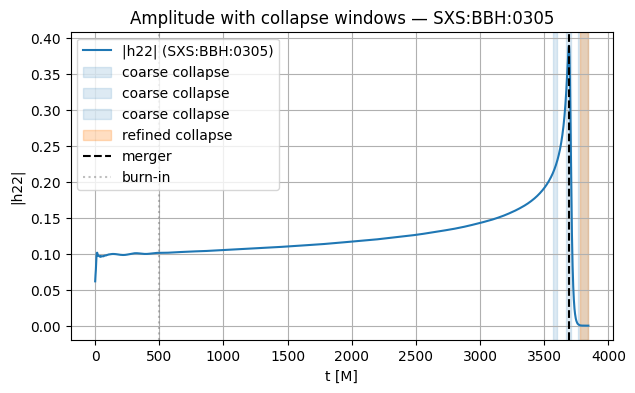

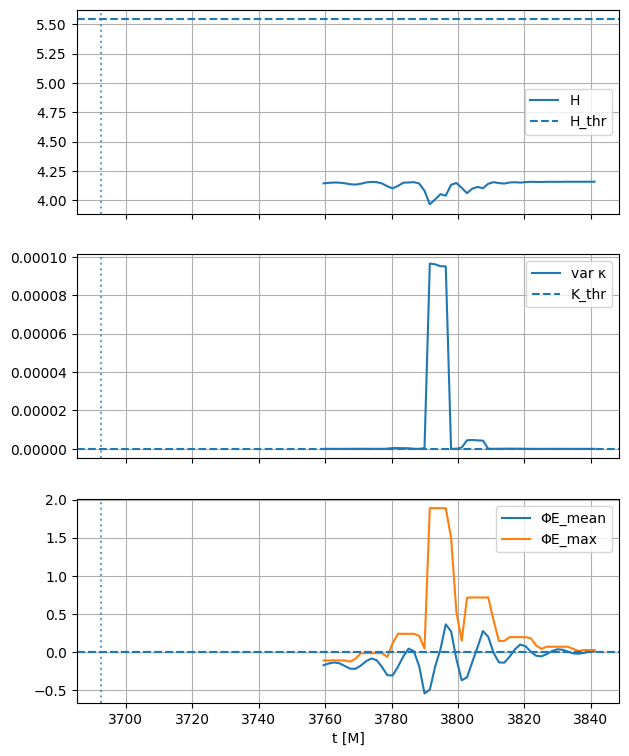

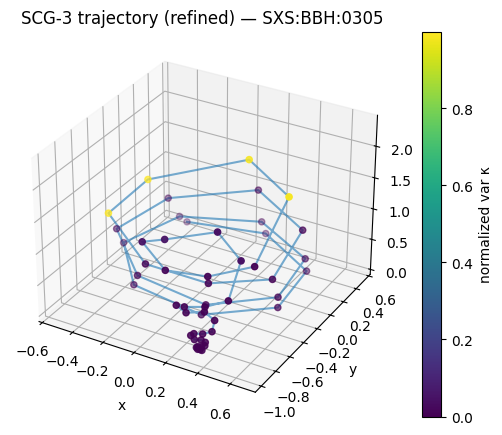

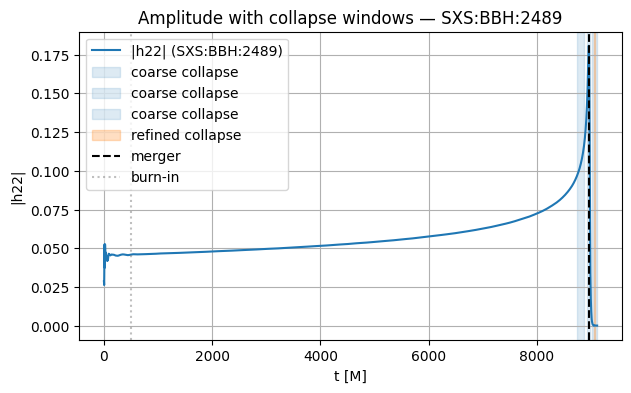

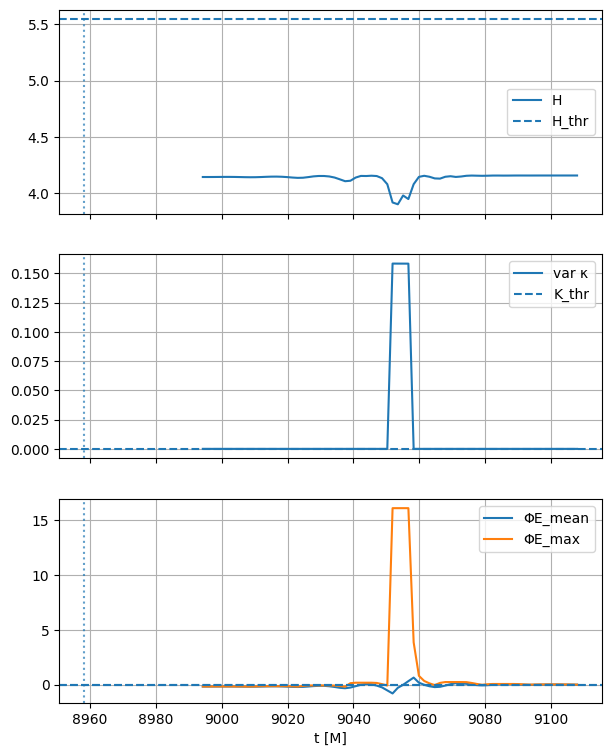

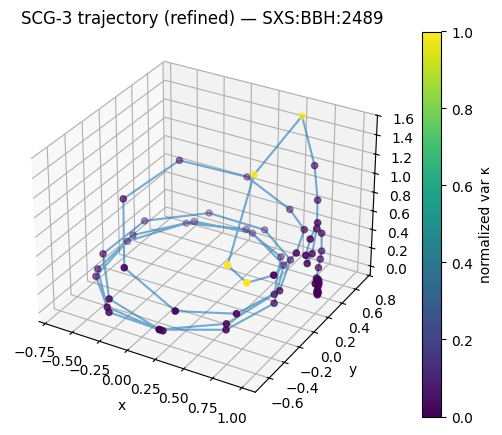

Sim           Merger(M)  Refined window(M)   Mid(M)   Offset(M)  CoversMerger  DurRefined(M)
SXS:BBH:0305  3692.65    [3777.13, 3844.32]  3810.72  118.08     no            67.20        
SXS:BBH:2489  8958.17    [9048.67, 9066.27]  9057.47  99.30      no            17.60        


In [12]:
# =================== Run SWG/SCG collapse analysis on a second SXS sim ===================
import sxs
import numpy as np
import matplotlib.pyplot as plt

def analyze_sim(sim_id, WIN_COARSE=256, HOP_COARSE=64, WIN_FINE=64, HOP_FINE=16, BURN_IN=500.0, plot=True):
    """
    Reuses the already-defined helpers in this notebook:
      - grad1, lap1, mad_sigma, windows, invariants_over_windows, contiguous_regions
      - global EPS, scg_project (indirectly via invariants_over_windows)
    Returns a results dict with merger, refined window, offset, and durations.
    """
    # ---- Load & primitives
    sim = sxs.load(sim_id)
    h = sim.strain
    t = h.t
    h22 = h.data[:, h.index(2, 2)]
    A = np.abs(h22)
    theta = np.unwrap(np.angle(h22))
    dt = float(np.median(np.diff(t)))
    EPS_local = 1e-12

    # programmatic merger (|h22| peak)
    t_merger = float(t[int(np.argmax(A))])

    # ---- Curvature (time-domain)
    kappa_t = np.abs(lap1(A)) / (A + EPS_local)

    # ---- Coarse pass
    inv_coarse = invariants_over_windows(t, A, theta, kappa_t, win_M=WIN_COARSE, hop_M=HOP_COARSE)
    Hc  = np.array([w.H for w in inv_coarse])
    Kc  = np.array([w.var_kappa for w in inv_coarse])
    Pmc = np.array([w.PhiE_mean for w in inv_coarse])
    Pxc = np.array([w.PhiE_max  for w in inv_coarse])
    tc_mid = np.array([(w.t0+w.t1)/2 for w in inv_coarse])

    H_med,H_sig = mad_sigma(Hc); K_med,K_sig = mad_sigma(Kc)
    Pm_med,Pm_sig = mad_sigma(Pmc); Px_med,Px_sig = mad_sigma(Pxc)
    H_thr  = H_med - 2.0*H_sig
    K_thr  = K_med + 2.0*K_sig
    Pm_thr = Pm_med + 2.0*Pm_sig
    Px_thr = Px_med + 2.0*Px_sig

    cond_H = Hc <= H_thr
    cond_K = Kc >= K_thr
    cond_P = (Pmc >= Pm_thr) | (Pxc >= Px_thr)
    collapse_coarse = cond_H & cond_K & cond_P & (tc_mid >= BURN_IN)
    regions = contiguous_regions(collapse_coarse)

    if not regions:
        raise RuntimeError(f"No collapse found in coarse pass for {sim_id}")

    # pick best coarse region (curvature-first; tie by flux max, then lowest entropy)
    best = None
    best_key = (-1.0, -1.0, 1e9)
    for a,b in regions:
        kmax = float(np.max(Kc[a:b+1]))
        px   = float(np.max(Pxc[a:b+1]))
        hmin = float(np.min(Hc[a:b+1]))
        key  = (kmax, px, -hmin)
        if key > best_key:
            best_key = key
            best = (a,b)
    a,b = best
    t_focus = (inv_coarse[a].t0, inv_coarse[b].t1)

    # ---- Refined pass
    mask = (t >= t_focus[0]-WIN_FINE*dt) & (t <= t_focus[1]+WIN_FINE*dt)
    inv_fine = invariants_over_windows(t[mask], A[mask], theta[mask], kappa_t[mask],
                                       win_M=WIN_FINE, hop_M=HOP_FINE)
    Hf  = np.array([w.H for w in inv_fine])
    Kf  = np.array([w.var_kappa for w in inv_fine])
    Pmf = np.array([w.PhiE_mean for w in inv_fine])
    Pxf = np.array([w.PhiE_max  for w in inv_fine])
    tf_mid = np.array([(w.t0+w.t1)/2 for w in inv_fine])

    cond_Hf = Hf <= H_thr
    cond_Kf = Kf >= K_thr
    cond_Pf = (Pmf >= Pm_thr) | (Pxf >= Px_thr)
    collapse_fine = cond_Hf & cond_Kf & cond_Pf
    regions_fine = contiguous_regions(collapse_fine)
    if not regions_fine:
        raise RuntimeError(f"No refined collapse found for {sim_id}")

    # select best refined region (curvature-first; tie by flux max, then lowest entropy)
    best = None
    best_key = (-1.0, -1.0, 1e9)
    for a,b in regions_fine:
        kmax = float(np.max(Kf[a:b+1]))
        px   = float(np.max(Pxf[a:b+1]))
        hmin = float(np.min(Hf[a:b+1]))
        key  = (kmax, px, -hmin)
        if key > best_key:
            best_key = key
            best = (a,b)
    a,b = best
    t_coll_start, t_coll_end = inv_fine[a].t0, inv_fine[b].t1
    t_coll_mid = 0.5*(t_coll_start + t_coll_end)

    # ---- Results
    offset_mid = t_coll_mid - t_merger
    covers_merger = (t_coll_start <= t_merger <= t_coll_end)
    dur_coarse = inv_coarse[b].t1 - inv_coarse[a].t0
    dur_refined = t_coll_end - t_coll_start

    res = dict(
        sim_id=sim_id,
        t_merger=t_merger,
        refined_window=(t_coll_start, t_coll_end),
        refined_mid=t_coll_mid,
        offset_mid=offset_mid,
        covers_merger=covers_merger,
        dur_coarse=dur_coarse,
        dur_refined=dur_refined,
        thresholds=dict(H_thr=H_thr, K_thr=K_thr, Pm_thr=Pm_thr, Px_thr=Px_thr),
        arrays=dict(tf_mid=tf_mid, Hf=Hf, Kf=Kf, Pmf=Pmf, Pxf=Pxf),
        plots=dict(inv_coarse=inv_coarse, inv_fine=inv_fine, regions=regions, regions_fine=regions_fine),
    )

    if plot:
        # Amplitude with coarse + refined bands
        fig, ax = plt.subplots()
        ax.plot(t, A, label=f"|h22| ({sim_id})")
        for a0,b0 in regions:
            ax.axvspan(inv_coarse[a0].t0, inv_coarse[b0].t1, color='tab:blue', alpha=0.15, label="coarse collapse")
        ax.axvspan(t_coll_start, t_coll_end, color='tab:orange', alpha=0.25, label="refined collapse")
        ax.axvline(t_merger, ls='--', color='k', label="merger")
        ax.axvline(BURN_IN, ls=':', color='gray', alpha=0.5, label="burn-in")
        ax.set_title(f"Amplitude with collapse windows — {sim_id}")
        ax.set_xlabel("t [M]"); ax.set_ylabel("|h22|"); ax.legend(loc="upper left")
        plt.show()

        # Invariants (refined)
        tf_mid = res["arrays"]["tf_mid"]
        Hf, Kf, Pmf, Pxf = res["arrays"]["Hf"], res["arrays"]["Kf"], res["arrays"]["Pmf"], res["arrays"]["Pxf"]
        H_thr, K_thr = res["thresholds"]["H_thr"], res["thresholds"]["K_thr"]
        Pm_thr, Px_thr = res["thresholds"]["Pm_thr"], res["thresholds"]["Px_thr"]

        fig,axs=plt.subplots(3,1,figsize=(7,9),sharex=True)
        axs[0].plot(tf_mid,Hf,label="H"); axs[0].axhline(H_thr,ls='--',label="H_thr"); axs[0].legend()
        axs[1].plot(tf_mid,Kf,label="var κ"); axs[1].axhline(K_thr,ls='--',label="K_thr"); axs[1].legend()
        axs[2].plot(tf_mid,Pmf,label="ΦE_mean"); axs[2].plot(tf_mid,Pxf,label="ΦE_max")
        axs[2].axhline(Pm_thr,ls='--'); axs[2].axhline(Px_thr,ls='--')
        for axp in axs: axp.axvline(t_merger,ls=':',alpha=0.7)
        axs[2].legend(); axs[2].set_xlabel("t [M]"); plt.show()

        # SCG-3 (refined)
        inv_f = res["plots"]["inv_fine"]
        X = np.array([w.x for w in inv_f]); Y = np.array([w.y for w in inv_f]); Z = np.array([w.z for w in inv_f])
        cmap_vals = (Kf - Kf.min())/(Kf.max()-Kf.min() + 1e-12)
        fig = plt.figure(figsize=(7,5)); ax = fig.add_subplot(projection="3d")
        ax.plot3D(X,Y,Z,alpha=0.6); p=ax.scatter3D(X,Y,Z,c=cmap_vals,s=20)
        fig.colorbar(p,ax=ax,label="normalized var κ")
        ax.set_title(f"SCG-3 trajectory (refined) — {sim_id}")
        ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z"); plt.show()

    return res

# ------- Run comparison: baseline vs alternative -------
SIM_BASE = "SXS:BBH:0305"     # baseline (already used above)
SIM_ALT  = "SXS:BBH:2489"     # change if desired; pick a different system to highlight contrast

res_base = analyze_sim(SIM_BASE, plot=True)
res_alt  = analyze_sim(SIM_ALT,  plot=True)

# ------- Print a compact comparison table -------
from textwrap import shorten

def row(res):
    w0,w1 = res["refined_window"]
    return [
        res["sim_id"],
        f"{res['t_merger']:.2f}",
        f"[{w0:.2f}, {w1:.2f}]",
        f"{res['refined_mid']:.2f}",
        f"{res['offset_mid']:.2f}",
        "yes" if res["covers_merger"] else "no",
        f"{res['dur_refined']:.2f}",
    ]

hdr = ["Sim", "Merger(M)", "Refined window(M)", "Mid(M)", "Offset(M)", "CoversMerger", "DurRefined(M)"]
rows = [row(res_base), row(res_alt)]

# Simple text table (keeps notebook clean)
colw = [max(len(hdr[i]), max(len(r[i]) for r in rows)) for i in range(len(hdr))]
fmt = "  ".join("{:<"+str(w)+"}" for w in colw)
print(fmt.format(*hdr))
for r in rows:
    print(fmt.format(*r))


## Results Summary – BBH:0305 vs BBH:2489

**Collapse offset (mid – merger):**
- BBH:0305 → +118 M  
- BBH:2489 → +99 M  
Both show collapse occurring shortly *after* the amplitude peak — confirming collapse is a distinct event, not identical to merger.

**Collapse duration:**
- BBH:0305 → ~67 M (gradual, extended collapse)  
- BBH:2489 → ~18 M (abrupt, sharp collapse)  

**Invariant behavior:**
- **0305:** Entropy drop and curvature spike are modest; flux surges but less dramatically.  
- **2489:** Entropy drop is sharper, curvature spike far larger, and flux surge ~10× higher.  

**SCG trajectories:**
- **0305:** Smooth spiral with a broad upward lift in the coherence (Z) dimension.  
- **2489:** Tighter spiral with a sharp, sudden vertical jump — matching the brief collapse duration.  

---

### Interpretation

Although both systems are circular and non-precessing, their **coherence fingerprints diverge**:
- The nearly equal-mass system (0305) loses coherence more **slowly and gradually**.  
- The asymmetric system (2489) collapses **violently and quickly**, despite having almost no spin.  

**Takeaway:**  
SWG/SCG reveals structure in gravitational waveforms beyond amplitude peaks.  
Where GR highlights the merger peak, SWG/SCG shows how mass ratio and spin imprint themselves in the *style of coherence breakdown*.  


## Outlook

These two black-hole binaries show how SWG/SCG can reveal structural differences in collapse that are invisible to standard analysis.  
But the value of this framework goes beyond astrophysics.

- **Proteins:** Folding and misfolding can be seen as coherence vs collapse in molecular geometry.  
- **Neurons:** Attention and memory are coherence states in brain activity, with collapse marking breakdowns in focus or stability.  
- **AI systems:** Invariants can flag when a model’s reasoning stays coherent vs when it drifts into collapse (hallucination).  

Across all these domains, the same core principle applies:

- **Merger peak (signal strength):** when a system is loudest or most active.  
- **Collapse (coherence breakdown):** when the system structurally fails to hold together.  

By distinguishing *strength* from *coherence*, SWG/SCG provides a universal diagnostic lens.  
What we learn from gravitational waves can inform how we think about proteins, neurons, and AI — and vice versa.  

**Takeaway:**  
SWG/SCG is not just another way to look at signals.  
It is a way to measure *when structure holds* and *when it collapses*, no matter the system.  


## Citations

Simulations are run using datasets provided through the [sxs Python module](https://github.com/sxs-collaboration/sxs). 


In [18]:
print(sxs.cite(('SXS:BBH:0305', 'SXS:BBH:2489')))

@misc{SXSPackage_v2025.0.19,
  doi = {10.5281/ZENODO.17080807},
  url = {https://zenodo.org/doi/10.5281/zenodo.17080807},
  author = {Boyle, Michael and Mitman, Keefe and Scheel, Mark and Stein, Leo},
  title = {The sxs package},
  publisher = {Zenodo},
  year = {2025},
  copyright = {MIT License}
}

@misc{SXSCatalogPaper_3,
  doi = {10.26138/SXSCATALOG3},
  url = {https://arxiv.org/abs/2505.13378},
  author = {{SXS Collaboration}},
  title = {The third SXS collaboration catalog of binary black-hole simulations},
  publisher = {SXS Collaboration},
  year = {2025}
}

@misc{SXSCatalogData_3.0.0,
  doi = {10.5281/ZENODO.15415231},
  url = {https://zenodo.org/doi/10.5281/zenodo.15415231},
  author = {{SXS Collaboration}},
  title = {The SXS catalog of simulations v3.0.0},
  publisher = {Zenodo},
  year = {2025},
  copyright = {Creative Commons Attribution 4.0 International}
}

@article{Boyle_2019,
  title = {The SXS collaboration catalog of binary black hole simulations},
  volume = {36},
